In [1]:
import pandas as pd
import lightgbm as lgb 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from arion.models.core import  ArionModel
import pickle
from datetime import datetime

In [2]:
df_race = pd.read_csv("../data/processed.csv", parse_dates=['date','datetime'])

In [2]:
racecard = pd.read_csv(f'../data/racecards/processed/{datetime.today().strftime("%Y_%m_%d")}.csv')

In [3]:
race = racecard.loc[racecard['race_id'] == 804351]

In [4]:
race['last_price'] = [26,46,3.05,3.5,3.65,13]

/var/folders/4n/bjfxt15j0rz22bn518w__b500000gn/T/ipykernel_18591/4045980803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race['last_price'] = [26,46,3.05,3.5,3.65,13]


In [51]:
model.predict(race)

array([0.03780783, 0.0134843 , 0.25356297, 0.33373991, 0.23123365,
       0.06972879])

In [6]:
model = pickle.load(open( "../artifacts/trained_model.pkl", "rb"))

In [8]:
model.make_bets(race)

,date,horse_name,last_price,model_prob,kelly,bet,bet_size
54,2022-03-11,Graffiti,26.00,0.044110,0.005875,False,0.000000
55,2022-03-11,Thermometer,46.00,0.011965,-0.009992,False,-0.000000
56,2022-03-11,Government,3.05,0.225892,-0.151722,False,-0.000000
57,2022-03-11,Aegis Power,3.50,0.314550,0.040370,True,20.184975
58,2022-03-11,Illuminated,3.65,0.213146,-0.083780,False,-0.000000
59,2022-03-11,Young Winston,13.00,0.060186,-0.018132,False,-0.000000


In [27]:
train = df_race.loc[(df_race.date < '2021-01-01')].copy()
test = df_race.loc[(df_race.date >= '2021-01-01') & (df_race.date < '2021-12-01')].copy()

not_features = ['race_id','date','datetime','won','price','horse_name','finish_pos']

In [4]:
model = ArionModel(not_features=not_features)
model.train(train=train)

[LightGBM] [Info] Total Bins 40464
[LightGBM] [Info] Number of data points in the train set: 697222, number of used features: 172
[LightGBM] [Info] Total Bins 40478
[LightGBM] [Info] Number of data points in the train set: 522916, number of used features: 172
[LightGBM] [Info] Total Bins 40468
[LightGBM] [Info] Number of data points in the train set: 522916, number of used features: 172
[LightGBM] [Info] Total Bins 40464
[LightGBM] [Info] Number of data points in the train set: 522917, number of used features: 172
[LightGBM] [Info] Total Bins 40398
[LightGBM] [Info] Number of data points in the train set: 522917, number of used features: 172
[LightGBM] [Info] Number of positive: 74797, number of negative: 622425
[LightGBM] [Info] Total Bins 40974
[LightGBM] [Info] Number of data points in the train set: 697222, number of used features: 174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [5]:
model.predict(X=test)

array([0.21076885, 0.2362275 , 0.11928718, ..., 0.04279075, 0.17325493,
       0.01405589])

In [105]:
y_rank = train["finish_pos"]
y = train['won']
skf = StratifiedKFold(n_splits=4)
oof = np.zeros(len(train))

callbacks = [lgb.early_stopping(40, verbose=0), lgb.log_evaluation(period=0)]

rank_params = {
    'boost_from_average':False,
    'num_leaves': 64,
    'objective': 'lambdarank',
    'num_threads': 7,
    'eta': 0.02,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'max_depth': 12,
    "lambda_l2":0,
    "drop_rate":0,
    'min_data_in_leaf': 3000,
    'force_col_wise':True
    }

for train_index, test_index in skf.split(train,y):
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train_rank, y_val_rank = y_rank.iloc[train_index], y_rank.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    q_train = X_train["race_id"].value_counts()[X_train["race_id"].unique()]
    q_val = X_val["race_id"].value_counts()[X_val["race_id"].unique()]

    X_train = X_train.drop(columns=not_features)
    X_val = X_val.drop(columns=not_features)

    dtrain = lgb.Dataset(X_train,label = y_train_rank,free_raw_data=False,
                            group = q_train)
    dval = lgb.Dataset(X_val,label = y_val_rank,free_raw_data=False,
                            group = q_val,reference=dtrain)
    
    model = lgb.train(rank_params,
                    dtrain,
                    valid_sets=[dtrain, dval],
                    num_boost_round=200,
                    callbacks = callbacks
                )
    
    y_pred = -model.predict(X_val)    
    oof[test_index] = y_pred

[LightGBM] [Info] Total Bins 40434
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40425
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40434
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40396
[LightGBM] [Info] Number of data points in the train set: 486408, number of used features: 172


In [106]:
# #Train final model on full training set
y_train_rank = train['finish_pos']
y_val_rank = val['finish_pos']

X_train = train.drop(columns=not_features)
X_val = val.drop(columns=not_features)
X_test = test.drop(columns=not_features)

q_train = train["race_id"].value_counts()[train["race_id"].unique()]
q_val = val["race_id"].value_counts()[val["race_id"].unique()]

dtrain = lgb.Dataset(X_train,label = y_train_rank,free_raw_data=False,
                            group = q_train)
dval = lgb.Dataset(X_val,label = y_val_rank,free_raw_data=False,
                            group = q_val,reference=dtrain)

lgbst_rank = lgb.train(rank_params,
                    dtrain,
                    valid_sets=[dtrain, dval],
                    num_boost_round=200,
                    callbacks = callbacks
                )

train["rank"] = oof
train["prob"] = train[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))

val["rank"] =  -lgbst_rank.predict(X_val)
val["prob"] = val[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))


test["rank"] =  -lgbst_rank.predict(X_test)
test["prob"] = test[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))

[LightGBM] [Info] Total Bins 40432
[LightGBM] [Info] Number of data points in the train set: 648543, number of used features: 172


In [107]:
X_train = train.drop(columns=not_features)
X_val = val.drop(columns=not_features)
X_test = test.drop(columns=not_features)

In [117]:
y_train = train['won']
y_val = val['won']
y_test = test['won']
callbacks = [ lgb.log_evaluation(period=50)]

params = {
            'boost_from_average':False,
            'num_leaves': 64,
            'objective': 'binary',
            'num_threads': 7,
            'eta': 0.04,
            'bagging_fraction': 0.9,
            'bagging_freq': 2,
            'max_depth': 16,
            "lambda_l2":0,
            "drop_rate":0.3,
            'min_data_in_leaf': 3000,
            "metric":'binary_logloss',
            'force_col_wise':True
            }

train_lgb = lgb.Dataset(X_train,label = y_train,free_raw_data=False)
val_lgb = lgb.Dataset(X_val,label = y_val,free_raw_data=False,reference = train_lgb)

lgbst = lgb.train(train_set = train_lgb,params = params, valid_sets=val_lgb,
                     num_boost_round=400, callbacks=callbacks)

[LightGBM] [Info] Number of positive: 69689, number of negative: 578854
[LightGBM] [Info] Total Bins 40942
[LightGBM] [Info] Number of data points in the train set: 648543, number of used features: 174
[50]	valid_0's binary_logloss: 0.307424
[100]	valid_0's binary_logloss: 0.287722
[150]	valid_0's binary_logloss: 0.2865
[200]	valid_0's binary_logloss: 0.286279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's binary_logloss: 0.28622
[300]	valid_0's binary_logloss: 0.286189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's binary_logloss: 0.286261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.286363


In [29]:
def bet_simulate(t, kelly_min, prob_min ,starting_balance):
    trial = df_race.loc[t.index,["race_id","last_price","won","date","price"]].copy()

    trial["pred_prob"] =model.predict(X=t)
    trial["pred_sp"] = 1/trial["pred_prob"]
    trial["kelly"] = ((trial["pred_prob"]*trial["last_price"]) - 1)/(trial["last_price"] - 1)
    
    trial["bet"] = (trial["pred_prob"] > prob_min)  & (trial['kelly'] > kelly_min)
    isnoise = [len(str(i)) > 5 for i in trial["last_price"]]
    #trial.loc[isnoise,"last_price"] = trial.loc[isnoise,"dec"]
    trial["winnings"] = (trial['bet'] * trial["kelly"] * starting_balance * trial["last_price"] * trial["won"] * 0.95) - (trial['bet'] * trial["kelly"] * starting_balance)
    trial["bank"] = trial["winnings"].cumsum()
    trial["bet size"] = trial["bet"]*trial["kelly"]*starting_balance

    return trial

def evaluate(t,prob_min = 0.2,kelly_min = 0.05):


    t = bet_simulate(t,prob_min=prob_min,kelly_min=kelly_min ,starting_balance = 100)

    roi = sum(t["winnings"])/sum(t["bet"] * t["kelly"] * 100)
    sr = sum((t['bet']) & (t['won']))/sum(t["bet"])

    final_balance = round(int(t['bank'][-1:]),2)
    bets_per_day = round(sum(t['bet'])/len(t['date'].unique()),2)
    ROI = round(roi*100,2)
    SR = round(sr*100,2)
    min_balance = round(min(t["bank"]),2) + 100 
    avg_betsize_day = t.groupby('date')['bet size'].sum()
    avg_bet_size = round(t.loc[t['bet'] ==1,"bet size"].mean(),2)
    max_bet = round(t.loc[t['bet'] ==1,"bet size"].max(),2)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plot = plt.plot(t['date'],t['bank'], label = "prob:" + str(prob_min)+ " kelly:" + str(kelly_min))
    plt.legend()
    out = {'prob_min':prob_min,
           'kelly_min':kelly_min,
           'final_balance':final_balance,
           'bets_per_day':bets_per_day,
           'ROI':ROI,
           'SR':SR,
           'min_balance':min_balance,
           'avg_bet_size':avg_bet_size,
           'max_bet':max_bet}

    return out,plot


In [13]:
t = bet_simulate(test, kelly_min=0.03, prob_min=0.2, starting_balance=500)

In [18]:
t.groupby('date')['bet size'].sum().mean()

523.9922150499235

,prob_min,kelly_min,final_balance,bets_per_day,ROI,SR,min_balance,avg_bet_size,max_bet
0,0.1,0.02,6464,28.48,10.55,22.16,78.34,6.94,50.73
1,0.1,0.03,6503,22.50,11.48,23.92,89.03,8.12,50.73
2,0.1,0.04,5619,17.64,10.94,25.32,89.03,9.40,50.73
3,0.2,0.02,5709,15.70,12.59,30.14,81.53,9.32,50.73
4,0.2,0.03,5863,14.15,13.28,30.82,72.30,10.06,50.73
5,0.2,0.04,5843,12.51,13.80,31.43,59.74,10.92,50.73
6,0.3,0.02,3088,7.68,10.31,38.04,84.44,12.57,50.73
7,0.3,0.03,3075,7.25,10.39,38.05,82.90,13.17,50.73
8,0.3,0.04,3087,6.84,10.59,38.21,86.54,13.75,50.73


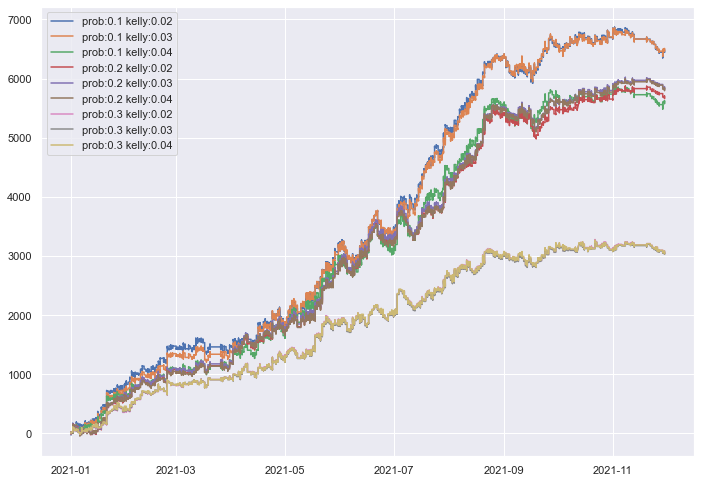

In [55]:
outs = []
params = []
for i in [0.1,0.2,0.3]:
    for j in [0.02,0.03,0.04]:
        params.append([i,j])
        outs.append(evaluate(test,prob_min=i, kelly_min = j))


pd.DataFrame([d[0] for d in outs])

In [22]:
print("Model val log-loss = ", log_loss(y_test,lgbst.predict(X_test)), "SP val log-loss = ", log_loss(y_test, 1/df_race.loc[X_test.index,"last_price"]))
plt.figure(figsize=(8, 6), dpi=80)
fop, mpv = calibration_curve(y_test, 1/df_race.loc[X_test.index,"last_price"],n_bins=20)
fop1, mpv1 = calibration_curve(y_test,lgbst.predict(X_test),n_bins=20)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv1, fop1, marker='.', color = "green")
plt.plot(mpv, fop, marker='.')

plt.show()

NameError: name 'y_test' is not defined